In [1]:

import pandas as pd
import math
import time
%matplotlib inline
import numpy as np
import pytz
from pytz import timezone
from pygeocoder import Geocoder
import numpy as np

import scipy.stats as stats
import matplotlib.pyplot as plt

def hr_func(ts):
    return ts.hour

df = pd.read_table('data/nyc_streamed_dataset2.txt', index_col=None)
df['eastern_time'] = pd.DatetimeIndex(pd.to_datetime(df.tweet_time)).tz_localize('UTC').tz_convert('US/Eastern')
df['hours'] = df['eastern_time'].apply(hr_func)
df['weekday'] = df['eastern_time'].dt.dayofweek
df['day_hour'] = df['weekday']*24 +  df['hours']
df.head()
#dropping rows for which we got invalid uber_estimate
df= df[df.uber_estimate > -1]
df.shape

(587, 11)

(-1, 24)

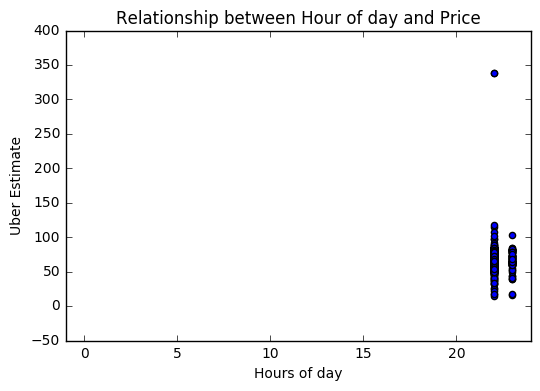

In [2]:
plt.scatter(df.hours, df.uber_estimate)
plt.xlabel("Hours of day")
plt.ylabel("Uber Estimate")
plt.title("Relationship between Hour of day and Price")
plt.xlim([-1,24])

(-1, 7)

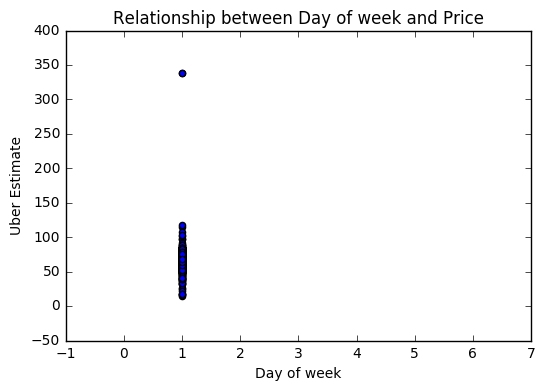

In [3]:
plt.scatter(df.weekday, df.uber_estimate)
plt.xlabel("Day of week")
plt.ylabel("Uber Estimate")
plt.title("Relationship between Day of week and Price")
plt.xlim([-1,7])

(-1, 168)

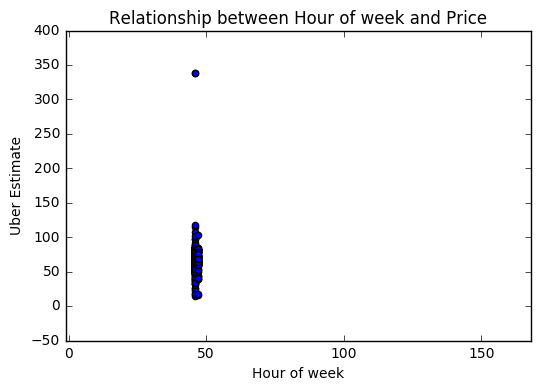

In [4]:
plt.scatter(df.day_hour, df.uber_estimate)
plt.xlabel("Hour of week")
plt.ylabel("Uber Estimate")
plt.title("Relationship between Hour of week and Price")
plt.xlim([-1,168])

In [5]:
bag_of_words = ['Construction','Ramp','Road','Incident','Accident','traffic','Friday','saturday','weekend', 'Terminal']
pattern = '|'.join(bag_of_words)
df['Is_Traffic_Related'] = df['tweet_text'].str.contains(pattern,case=False)
df.head()

,tweet_id,tweet_time,tweet_text,tweet_coordinates,lat_origin,long_origin,uber_estimate,eastern_time,hours,weekday,day_hour,Is_Traffic_Related
0,834239420740009984,2017-02-21 22:12:31-05:00,Inviting you over to see my M.I.A. Inspired Ma...,"[40.7142, -74.0064]",40.714200,-74.006400,65.0,2017-02-21 22:12:31-05:00,22,1,46,False
1,834239423260733440,2017-02-21 22:12:32-05:00,Classic ....custom made ... articlesofstyle sh...,"[40.72988718, -73.99608036]",40.729887,-73.996080,71.0,2017-02-21 22:12:32-05:00,22,1,46,False
2,834239428130283522,2017-02-21 22:12:33-05:00,#NYC New York by day #driving #streetview #tra...,"[40.74208978, -73.98823897]",40.742090,-73.988239,66.0,2017-02-21 22:12:33-05:00,22,1,46,True
3,834239442831306752,2017-02-21 22:12:37-05:00,We're #hiring! Read about our latest #job open...,"[40.7347942, -73.9895321]",40.734794,-73.989532,68.0,2017-02-21 22:12:37-05:00,22,1,46,False
4,834239511773270020,2017-02-21 22:12:53-05:00,"Respect all, fear none. Link to our shop here ...","[40.7829995, -73.9511195]",40.783000,-73.951119,56.0,2017-02-21 22:12:53-05:00,22,1,46,False


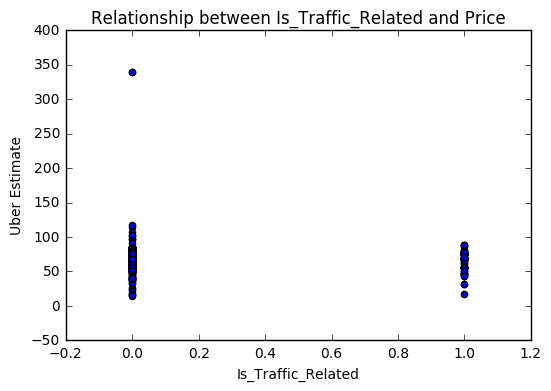

In [6]:
plt.scatter(df.Is_Traffic_Related, df.uber_estimate)
plt.xlabel("Is_Traffic_Related")
plt.ylabel("Uber Estimate")
plt.title("Relationship between Is_Traffic_Related and Price")
#plt.xlim([-1,168])

In [7]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(df[['day_hour','weekday','Is_Traffic_Related']], df.uber_estimate)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
lm.coef_

array([-1.29144605,  0.        , -3.15393551])

In [9]:
Y = lm.predict(df[['day_hour','weekday','Is_Traffic_Related']])

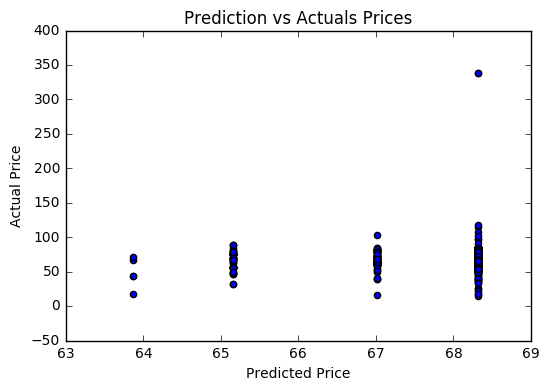

In [10]:
plt.scatter(Y, df.uber_estimate)
plt.title("Prediction vs Actuals Prices")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")

In [11]:
msePRC = np.mean((df.uber_estimate - lm.predict(df[['day_hour','weekday','Is_Traffic_Related']])) ** 2)
print (msePRC)
print (lm.coef_)

396.5441441897808
[-1.29144605  0.         -3.15393551]


In [12]:
ESS = np.sum(lm.predict(df[['day_hour','weekday','Is_Traffic_Related']]) - np.mean(df.uber_estimate)) ** 2
RSS = np.sum((df.uber_estimate - lm.predict(df[['day_hour','weekday','Is_Traffic_Related']])) ** 2)
R2 = ESS/(ESS+RSS)
print (R2)
                           

8.99544184202e-29


In [13]:
df.head()


,tweet_id,tweet_time,tweet_text,tweet_coordinates,lat_origin,long_origin,uber_estimate,eastern_time,hours,weekday,day_hour,Is_Traffic_Related
0,834239420740009984,2017-02-21 22:12:31-05:00,Inviting you over to see my M.I.A. Inspired Ma...,"[40.7142, -74.0064]",40.714200,-74.006400,65.0,2017-02-21 22:12:31-05:00,22,1,46,False
1,834239423260733440,2017-02-21 22:12:32-05:00,Classic ....custom made ... articlesofstyle sh...,"[40.72988718, -73.99608036]",40.729887,-73.996080,71.0,2017-02-21 22:12:32-05:00,22,1,46,False
2,834239428130283522,2017-02-21 22:12:33-05:00,#NYC New York by day #driving #streetview #tra...,"[40.74208978, -73.98823897]",40.742090,-73.988239,66.0,2017-02-21 22:12:33-05:00,22,1,46,True
3,834239442831306752,2017-02-21 22:12:37-05:00,We're #hiring! Read about our latest #job open...,"[40.7347942, -73.9895321]",40.734794,-73.989532,68.0,2017-02-21 22:12:37-05:00,22,1,46,False
4,834239511773270020,2017-02-21 22:12:53-05:00,"Respect all, fear none. Link to our shop here ...","[40.7829995, -73.9511195]",40.783000,-73.951119,56.0,2017-02-21 22:12:53-05:00,22,1,46,False


In [14]:
results = Geocoder.reverse_geocode(df['lat_origin'][1], df['long_origin'][1])
print(results.postal_code)

10003


In [15]:
# import time
#df['postal_code']=df.apply(lambda row: Geocoder.reverse_geocode(row['lat_origin'], row['long_origin']), axis=1)
fName = 'data/final_dataframe_dataset.txt'
with open(fName, 'w',1) as f:
   f.write("tweet_id\ttweet_time\ttweet_text\ttweet_coordinates\tlat_origin\tlong_origin\tuber_estimate\tzip_code\teastern_time\thours\tweekday\tday_hour\tIs_Traffic_Related\n")
   for index, row in df.iterrows():
       results = Geocoder.reverse_geocode(row['lat_origin'], row['long_origin'])
       time.sleep(.25)
       #f.flush()
       f.write(str(row['tweet_id']) 
               + '\t' + row['tweet_text'] + '\t' + row['tweet_coordinates']
               + '\t' + str(row['lat_origin'])  + '\t' + str(row['long_origin'])   
               + '\t' + str(row['uber_estimate']) + '\t' + str(results.postal_code)
               + '\t' + str(row['eastern_time']) + '\t' + str(row['hours']) 
               + '\t' + str(row['weekday']) + '\t' + str(row['day_hour'])  
               + '\t' + str(row['Is_Traffic_Related']) + '\n')
   f.close()


In [34]:
df1 = pd.read_table('data/final_op.txt', index_col=None)
df1.head()

,tweet_id,tweet_text,tweet_coordinates,lat_origin,long_origin,uber_estimate,zip_code,eastern_time,hours,weekday,day_hour,Is_Traffic_Related,County,Neighbourhood,Neighbourhood_code,Is_weekend
0,8.324278e+17,Yeezus gospel #tbt @ Madison Square Garden htt...,"[40.75079924, -73.99297235]",40.750799,-73.992972,70,10001,2017-02-16 22:13:36-05,22,3,94,f,New York,Chelsea and Clinton,8,0
1,8.324278e+17,"GNW! @ New York, New York https://t.co/Sqpnij3q4k","[40.7142, -74.0064]",40.714200,-74.006400,79,10007,2017-02-16 22:13:40-05,22,3,94,f,Manhattan,Lower Manhattan,20,0
2,8.324278e+17,Soulful Southern blues bass #guitar by @thatab...,"[40.7471587, -73.99463981]",40.747159,-73.994640,73,10001,2017-02-16 22:13:45-05,22,3,94,f,New York,Chelsea and Clinton,8,0
3,8.324278e+17,Construction on #I678 SB at Queens; Bronx Coun...,"[40.802501, -73.830001]",40.802501,-73.830001,37,11357,2017-02-16 22:13:55-05,22,3,94,t,Queens,North Queens,22,0
4,8.324278e+17,Construction on #I678 SB at Queens; Bronx Coun...,"[40.802501, -73.830001]",40.802501,-73.830001,37,11357,2017-02-16 22:13:55-05,22,3,94,t,Queens,North Queens,22,0


In [35]:
df1
df1['Is_Traffic_Related'] = df1['Is_Traffic_Related'].map({'t': 1, 'f': 0})
#df1['county'] = df1['county'].map({'Staten Island': 1, 'Bronx': 2, 'Queens': 3, 'Brooklyn': 4, 'Manhattan': 5})

# Group by Column to check count
df2=df1.groupby('Is_Traffic_Related').size()
df2
#lm = LinearRegression()
#lm.fit(df1[['day_hour','Is_weekend','is_traffic_related','county']], df1.uber_estimate)





Is_Traffic_Related
0    8332
1    1648
dtype: int64

In [36]:
lm = LinearRegression()
lm.fit(df1[['day_hour','Is_weekend','Is_Traffic_Related','Neighbourhood_code']], df1.uber_estimate)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
lm.coef_

array([ 0.02032079, -1.9683662 , -4.65740834,  0.05022306])

In [38]:
Y = lm.predict(df1[['day_hour','Is_weekend','Is_Traffic_Related','Neighbourhood_code']])

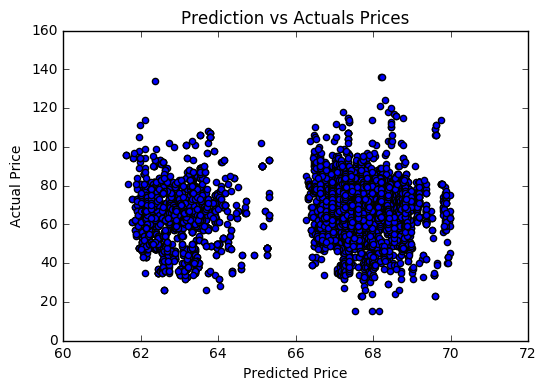

In [39]:
plt.scatter(Y, df1.uber_estimate)
plt.title("Prediction vs Actuals Prices")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")

In [40]:
msePRC = np.mean((df1.uber_estimate - lm.predict(df1[['day_hour','Is_weekend','Is_Traffic_Related','Neighbourhood_code']])) ** 2)
print (msePRC)
print (lm.coef_)

137.9420495662767
[ 0.02032079 -1.9683662  -4.65740834  0.05022306]


In [41]:
ESS = np.sum(lm.predict(df1[['day_hour','Is_weekend','Is_Traffic_Related','Neighbourhood_code']]) - np.mean(df1.uber_estimate)) ** 2
RSS = np.sum((df1.uber_estimate - lm.predict(df1[['day_hour','Is_weekend','Is_Traffic_Related','Neighbourhood_code']])) ** 2)
R2 = ESS/(ESS+RSS)
print (R2)

1.73592144471e-29


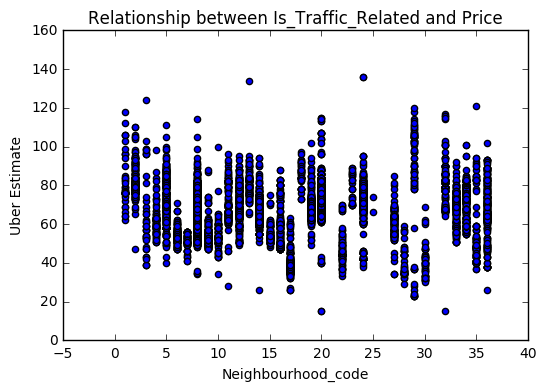

In [43]:
plt.scatter(df1.Neighbourhood_code, df1.uber_estimate)
plt.xlabel("Neighbourhood_code")
plt.ylabel("Uber Estimate")
plt.title("Relationship between Is_Traffic_Related and Price")
#plt.xlim([-1,168])

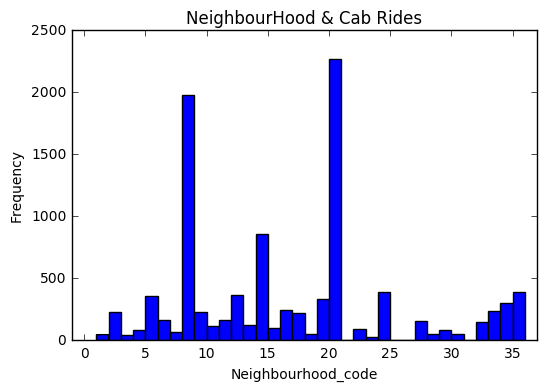

In [56]:
#plt.hist((df1.Neighbourhood_code)) 
binwidth = 1
plt.hist(df1.Neighbourhood_code, bins=np.arange(min(df1.Neighbourhood_code), max(df1.Neighbourhood_code) + binwidth, binwidth))
plt.title("NeighbourHood & Cab Rides")
plt.xlabel("Neighbourhood_code")
plt.ylabel("Frequency")
plt.xlim([-1,37])
#major_ticks = np.arange(0, 36, 1)  
#plt.xticks(major_ticks)
plt.show()



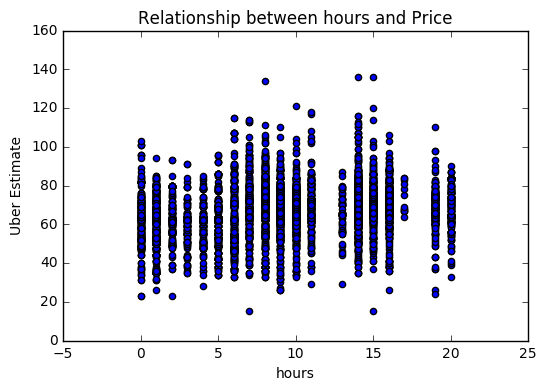

In [63]:
df1= df1[df1.Is_weekend==1]
df1
plt.scatter(df1.hours, df1.uber_estimate)
plt.xlabel("hours")
plt.ylabel("Uber Estimate")
plt.title("Relationship between hours and Price")
#plt.xlim([-1,168])

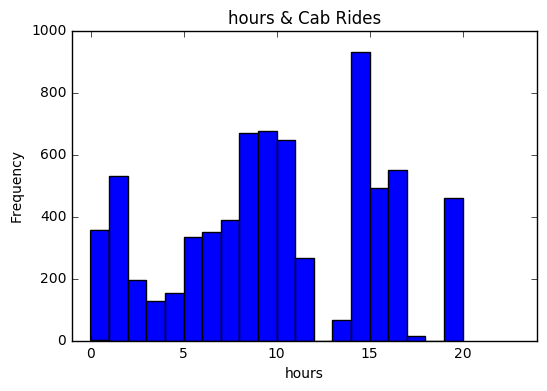

In [65]:
binwidth = 1
df1= df1[df1.Is_weekend==1]
plt.hist(df1.hours, bins=np.arange(min(df1.hours), max(df1.hours) + binwidth, binwidth))
plt.title("hours & Cab Rides")
plt.xlabel("hours")
plt.ylabel("Frequency")
plt.xlim([-1,24])
#major_ticks = np.arange(0, 36, 1)  
#plt.xticks(major_ticks)
plt.show()